In [20]:
import requests
import json 
import matplotlib.pyplot as plt

def getpath(nested_dict, value, prepath=()):
    for k, v in nested_dict.items():
        path = prepath + (k,)
        if v == value: # found value
            return path
        elif hasattr(v, 'items'): # v is a dict
            p = getpath(v, value, path) # recursive call
            if p is not None:
                return p

SLEEPER_ID = 802628454850875392
BASE_SLEEPER_URL = "https://api.sleeper.app/v1"
HIDDEN_SLEEPER_URL = "https://api.sleeper.app"

# retrieve all players
res = requests.get(BASE_SLEEPER_URL + "/players/nfl")
all_players = json.loads(res.text)

# retrieve managers
res = requests.get(BASE_SLEEPER_URL + "/league/{}/users".format(SLEEPER_ID))
response = json.loads(res.text)

users = []
for r in response:
    try:
        users.append({
            'user_id': r['user_id'],
            'user_name': r['display_name'],
            'team_name': r['metadata']['team_name']
        })
    except KeyError:
        users.append({
            'user_id': r['user_id'],
            'user_name': r['display_name'],
            'team_name': r['display_name']
        })
print(users)

[{'user_id': '208805784484577280', 'user_name': 'Moxham_Monarchs', 'team_name': 'Moxham Monarchs'}, {'user_id': '339158462208409600', 'user_name': 'burritophil', 'team_name': 'Squirrel Hill 🅱️aboons'}, {'user_id': '553246944279191552', 'user_name': 'jgiffin', 'team_name': 'Geistown Whistle Pigs'}, {'user_id': '553579833917870080', 'user_name': 'orlov127', 'team_name': 'Allaquippa Artisans'}, {'user_id': '609521889538277376', 'user_name': 'AdventurousSwine', 'team_name': 'Hogwarts Raptors'}, {'user_id': '846860747966365696', 'user_name': 'SouthOaklandOutlaws', 'team_name': 'South Oakland Outlaws'}, {'user_id': '855182840579600384', 'user_name': 'jasonmorine', 'team_name': 'The Garland Gravediggers'}, {'user_id': '855480251210412032', 'user_name': 'TonySoprano22', 'team_name': 'TonySoprano22'}, {'user_id': '855507719929569280', 'user_name': 'apeape', 'team_name': 'Ape'}, {'user_id': '855508686532108288', 'user_name': 'bigharv78', 'team_name': 'bigharv78'}, {'user_id': '855962622254788608

In [21]:
import statistics

# get draft picks
draft_2020_names = ["Jonathan Taylor","Clyde Edwards-Helaire","J.K. Dobbins","CeeDee Lamb","Cam Akers","Swift","Justin Jefferson","Jerry Jeudy","Henry Ruggs","Brandon Aiyuk","Jalen Reagor","Tee Higgins","Joe Burrow","Ke'Shawn Vaughn","Michael Pittman","Denzel Mims","AJ Dillon","Bryan Edwards","Zack Moss","Chase Claypool","Laviska Shenault","Tua Tagovailoa","Devin Duvernay","Anthony McFarland","Darrynton Evans","K.J. Hamler","Cole Kmet","Justin Herbert","Jack Doyle","Antonio Gibson","Van Jefferson","Gandy-Golden"]
draft_2020_users = [553246944279191552,856321409188769792,857059915070582784,856321409188769792,855508686532108288,609521889538277376,855182840579600384,857284701356920832,339158462208409600,855962622254788608,855480251210412032,609521889538277376,208805784484577280,855507719929569280,856681054394761216,609521889538277376,856321409188769792,855182840579600384,553579833917870080,857059915070582784,855508686532108288,609521889538277376,855182840579600384,857059915070582784,339158462208409600,855962622254788608,855480251210412032,609521889538277376,857662429260275712,855507719929569280,856681054394761216,609521889538277376]
draft_2020_data = []
draft_2021_names = ["Najee Harris","Ja'Marr Chase","Kyle Pitts","Travis Etienne","Javonte Williams","Trevor Lawrence","Jaylen Waddle","DeVonta Smith","Elijah Moore","Trey Sermon","Michael Carter","Trey Lance","Justin Fields","Terrace Marshall","Rashod Bateman","Rondale Moore","Joshua Palmer","Amon-Ra St. Brown","Kadarius Toney","Zach Wilson","Dyami Brown","Tutu Atwell","Kenneth Gainwell","Mac Jones","Chuba Hubbard","Pat Freiermuth","Rhamondre Stevenson","Nico Collins","","Anthony Schwartz","Amari Rodgers","Hunter Henry"]
draft_2021_users = [856681054394761216,553246944279191552,855480251210412032,857284701356920832,609521889538277376,855182840579600384,855508686532108288,855962622254788608,855507719929569280,609521889538277376,857059915070582784,553246944279191552,857662429260275712,339158462208409600,856321409188769792,609521889538277376,856321409188769792,609521889538277376,857059915070582784,857059915070582784,609521889538277376,856681054394761216,855508686532108288,855962622254788608,855507719929569280,609521889538277376,553579833917870080,855480251210412032,857662429260275712,339158462208409600,553579833917870080,855182840579600384]
draft_2021_data = []
draft_2022_names = ["Breece Hall","Kenneth Walker","Jameson Williams","Drake London","Chris Olave","Garrett Wilson","Jahan Dotson","Treylon Burks","Skyy Moore","George Pickens","James Cook","Christian Watson","Rachaad White","Isaiah Spiller","Kenny Pickett","Alec Pierce","David Bell","Jalen Tolbert","John Metchie","Dameon Pierce","Trey McBride","Brian Robinson","Tyquan Thornton","Khalil Shakir","Wan'Dale Robinson","Greg Dulcich","Malik Willis","Tyler Allgeier","Desmond Ridder","Romeo Doubs","Jelani Woods","Calvin Austin","Kyren Williams","Hassan Haskins","Tyrion Davis-Price","Daniel Bellinger","Sam Howell","Zamir White","Taysom Hill","Brock Purdy","Matt Corral","Brevin Jordan","Velus Jones","Pierre Strong","Justyn Ross","Nick Westbrook-Ikhine","","Gerald Everett"]
draft_2022_users = [208805784484577280,855962622254788608,855480251210412032,208805784484577280,855508686532108288,553579833917870080,857662429260275712,857284701356920832,609521889538277376,553246944279191552,857284701356920832,553579833917870080,856681054394761216,855507719929569280,208805784484577280,339158462208409600,857059915070582784,857059915070582784,609521889538277376,339158462208409600,855508686532108288,609521889538277376,857662429260275712,857284701356920832,609521889538277376,855507719929569280,855480251210412032,553579833917870080,856681054394761216,553246944279191552,857284701356920832,857059915070582784,855480251210412032,855962622254788608,609521889538277376,339158462208409600,855508686532108288,856321409188769792,857662429260275712,857284701356920832,609521889538277376,553246944279191552,856681054394761216,553579833917870080,856681054394761216,855182840579600384,855507719929569280,339158462208409600]
draft_2022_data = []

def get_draft_data(player_names, player_data, user_data, years):
    idx = 1
    for name in player_names:
        player_id = getpath(all_players, name)[0]
        total_fpts = 0
        fpts = []
        for year in years:
            try:
                res = requests.get(HIDDEN_SLEEPER_URL + "/stats/nfl/player/{}?season_type=regular&season={}".format(player_id, year))
                response = json.loads(res.text)
                fpts.append(response['stats']['pts_half_ppr'])
                total_fpts = total_fpts + response['stats']['pts_half_ppr']
            except:
                break

        mean = 0
        try:
            mean = statistics.mean(fpts)
        except:
            continue

        player_data.append({
            'id': player_id,
            'name': name,
            'draft_pos': idx,
            'total_fpts': total_fpts,
            'avg_fpts': mean,
            'fpts': fpts,
            'drafted_by_id': user_data[idx-1]
        })
        idx = idx + 1

get_draft_data(draft_2020_names, draft_2020_data, draft_2020_users, years = [2022,2021,2020])
get_draft_data(draft_2021_names, draft_2021_data, draft_2021_users, years = [2022,2021])
get_draft_data(draft_2022_names, draft_2022_data, draft_2022_users, years = [2022])


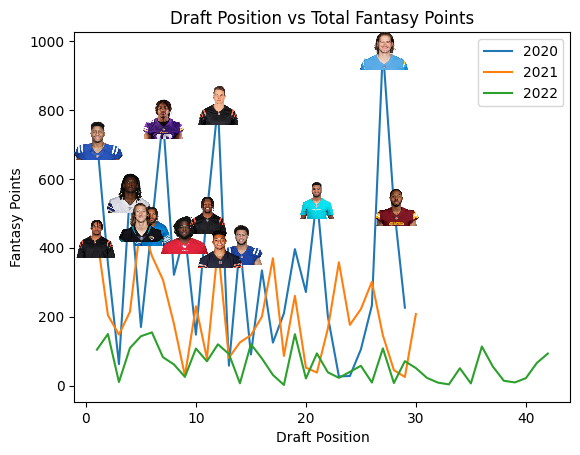

In [22]:
# plot the data basic linechart data
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import PIL
import urllib

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

fig, ax = plt.subplots()
def plot_draft_pos_data(data, year):
    x = []
    y = []
    for d in data:
        x.append(d['draft_pos'])
        y.append(d['total_fpts'])

        if d['total_fpts'] > 400:
            url = 'https://sleepercdn.com/content/nfl/players/{}.jpg'.format(d['id'])
            image = PIL.Image.open(urllib.request.urlopen(url))
            image.save('images/{}.png'.format(d['id']))
            imscatter(d['draft_pos'], d['total_fpts'], 'images/{}.png'.format(d['id']), zoom=0.15, ax=ax)

    ax.plot(x, y, label=year)
    plt.xlabel('Draft Position')
    plt.ylabel('Fantasy Points')
    plt.title('Draft Position vs Total Fantasy Points')
    plt.legend()

plot_draft_pos_data(draft_2020_data, '2020')
plot_draft_pos_data(draft_2021_data, '2021')
plot_draft_pos_data(draft_2022_data, '2022')

plt.show()


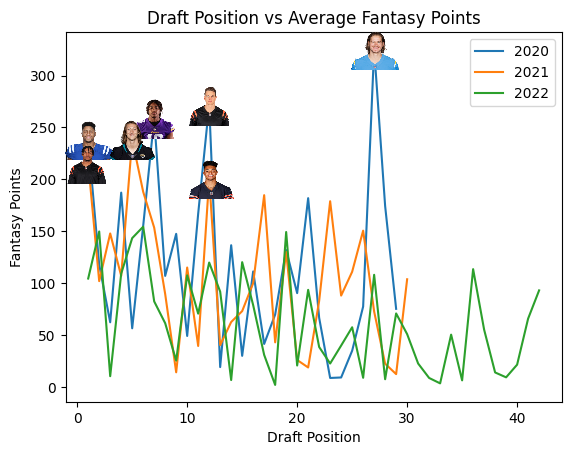

In [23]:
# plot the data basic linechart data
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import PIL
import urllib

fig, ax = plt.subplots()
def plot_draft_pos_data(data, year):
    x = []
    y = []
    for d in data:
        x.append(d['draft_pos'])
        y.append(d['avg_fpts'])

        if d['avg_fpts'] > 200:
            url = 'https://sleepercdn.com/content/nfl/players/{}.jpg'.format(d['id'])
            image = PIL.Image.open(urllib.request.urlopen(url))
            image.save('images/{}.png'.format(d['id']))
            imscatter(d['draft_pos'], d['avg_fpts'], 'images/{}.png'.format(d['id']), zoom=0.15, ax=ax)

    ax.plot(x, y, label=year)
    plt.xlabel('Draft Position')
    plt.ylabel('Fantasy Points')
    plt.title('Draft Position vs Average Fantasy Points')
    plt.legend()

plot_draft_pos_data(draft_2020_data, '2020')
plot_draft_pos_data(draft_2021_data, '2021')
plot_draft_pos_data(draft_2022_data, '2022')

plt.show()


In [60]:
# average fpts per draft position

avg_fpts_per_pick_raw = []
avg_fpts_per_pick_data = []


def add_averages(data):
    idx = 0
    for d in data:
        try:
            avg_fpts_per_pick_raw[idx].append(d['avg_fpts'])
        except:
            avg_fpts_per_pick_raw.append([d['avg_fpts']])
        idx = idx + 1

add_averages(draft_2020_data)
add_averages(draft_2021_data)
add_averages(draft_2022_data)

for d in avg_fpts_per_pick_raw:
    avg_fpts_per_pick_data.append(statistics.mean(d))
print(avg_fpts_per_pick_data)


[186.26111111111112, 123.32222222222222, 73.7, 134.6, 146.19, 165.9777777777778, 164.97333333333333, 86.15555555555557, 62.52777777777778, 90.74444444444444, 92.50777777777778, 197.57111111111112, 50.62222222222222, 68.77222222222223, 74.61, 96.84444444444445, 85.86111111111111, 38.43777777777778, 137.23222222222222, 45.87777777777778, 98.22222222222223, 62.85, 70.24, 45.888888888888886, 67.96666666666667, 79.13777777777777, 168.89, 68.21555555555555, 53.01111111111111, 77.5, 22.8, 8.9, 3.7, 50.6, 6.6, 113.64, 55.42, 14.2, 9.5, 21.7, 66.0, 93.2]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


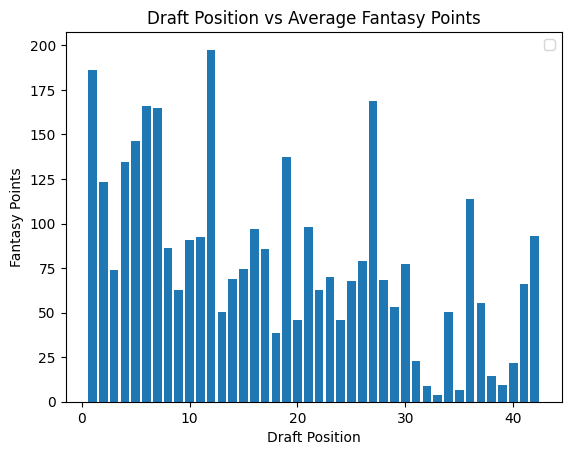

In [59]:
# graph the average fpts per pick

plt.bar(list(range(1, len(avg_fpts_per_pick_data)+1)), avg_fpts_per_pick_data)
plt.xlabel('Draft Position')
plt.ylabel('Fantasy Points')
plt.title('Draft Position vs Average Fantasy Points')
plt.legend()
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127345 (\N{NEGATIVE SQUARED LATIN CAPITAL LETTER B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


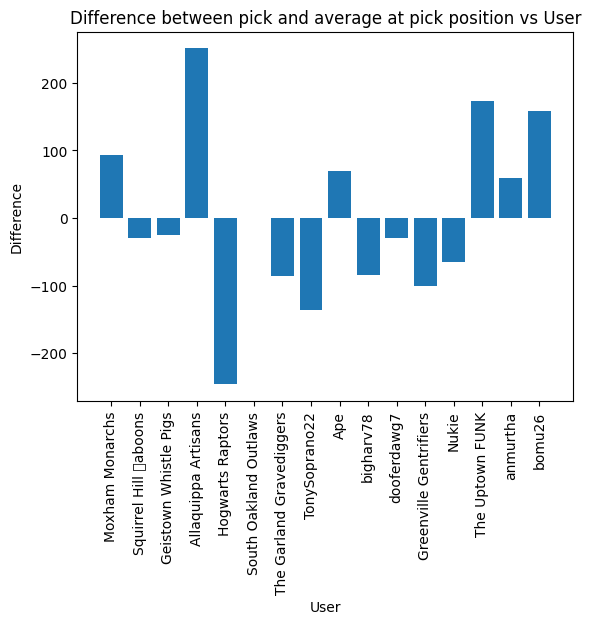

In [86]:
# points above average by user
user_avg_data = users.copy()

def find_players_fpts_avg_by_userid(user_id, draft_data):
    return [{'avg_fpts': d['avg_fpts'], 'draft_pos': d['draft_pos'], 'player_id': d['id']} for d in draft_data if str(d['drafted_by_id']) == str(user_id)]

for u in user_avg_data:
    u['data'] = []
    u['data'].extend(find_players_fpts_avg_by_userid(u['user_id'], draft_2020_data))
    u['data'].extend(find_players_fpts_avg_by_userid(u['user_id'], draft_2021_data))
    u['data'].extend(find_players_fpts_avg_by_userid(u['user_id'], draft_2022_data))

    # calculate the user's stdev from the expected
    u['difference_data'] = []
    for d in u['data']:
        dif = avg_fpts_per_pick_data[d['draft_pos'] - 1] - d['avg_fpts']
        u['difference_data'].append({'draft_pos': d['draft_pos'], 'difference': dif, 'player_id': d['player_id']})

# calculate total sum of difference
net_user_avg_draft_values = []
net_user_avg_draft_names = []
for u in user_avg_data:
    net_user_avg_draft_values.append(sum([d['difference'] for d in u['difference_data']]))
    net_user_avg_draft_names.append(u['team_name'])

# graph
plt.bar(net_user_avg_draft_names,net_user_avg_draft_values)
plt.xlabel('User')
plt.ylabel('Difference')
plt.xticks(rotation=90)
plt.title('Difference between pick and average at pick position vs User')
plt.show()
